In [239]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  

year  = (1*u.year).cgs.value
au    = c.au.cgs.value
M_jup = c.M_jup.cgs.value
M_sun = c.M_sun.cgs.value

gl_alpha = None

import os
import simple_slider

from simple_slider import Widget
from simple_slider import kanagawa_profile
from simple_slider import get_surface_density
from simple_slider import get_disk_height

from log_prob import logp, log_prior, log_prob, conv_values, params_format, log_prob_alpha

%matplotlib notebook

Select the number of planets

Choices: {1,3}

In [240]:
gl_n_planets = 1

Optional: Set desired alpha here (uncomment second line)

In [241]:
##################
gl_alpha = 1e-2
##################

try:
    set_alpha = int(gl_alpha**0)
except Exception:
    set_alpha = 0

In [242]:
if gl_n_planets == 3:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_3_planets')
elif gl_n_planets == 1:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_1_planet')
else:
    print("please select valid value for gl_n_planets")

##################
switcher = {0:"data_one_planet_a1e-2_M1e-3",1:"data_one_planet_a1e-2_M4e-4",2:"data_one_planet_a1e-3_M1e-3",3:"data_one_planet_a1e-3_M4e-4"}
data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, switcher[1])
##################

r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)

Interpolate on a log grid

In [243]:
n_points = 500
r_log = np.logspace(np.log10(20), np.log10(400), n_points) * au
#sigma_log = 10.**np.array([np.interp(np.log10(r_log), np.log10(r), np.log10(sig)) for sig in sigma.T]).T
try:
    time = np.loadtxt(os.path.join(data_dir, 'time.dat'))
    t   = time.searchsorted(5 * 1e4 * year)
    #t  = 0
    sigma = sigma[:, t]
except Exception:
    None
    
sig = 10.**np.array(np.interp(np.log10(r_log), np.log10(r), np.log10(sigma)))

Select the snapshot

t   = time.searchsorted(5 * 1e4 * year)
#t  = 0
sig = sigma_log[:, t]

Define the logp function: create a model based on the parameters and compare it to the data

In [244]:
import emcee
from multiprocessing import Pool


nwalkers = 300
ndim = 3 + 2 * gl_n_planets - set_alpha
n_burnin = 500
n_steps = 700
pos = np.random.rand(nwalkers, ndim)

if gl_alpha is not None:
    pos = np.insert(pos,0,0,axis=1)

pos = conv_values(pos, r_log, gl_n_planets)

# both implementations work to some extent
# in order to switch starting positions move the """ from the 
# first line of the if function to the last or vice versa

if gl_n_planets == 3:
    """# find local minima
    from scipy.signal import argrelmin
    peaks_mask = argrelmin(sig, order=int(n_points/33))
    rps = r_log[peaks_mask]
    # place Gaussians around minima as starting guesses
    pos[:,3] = (rps[0]*(1+np.random.randn(pos.shape[0])*0.025))
    pos[:,5] = (rps[1]*(1+np.random.randn(pos.shape[0])*0.025))
    pos[:,7] = (rps[2]*(1+np.random.randn(pos.shape[0])*0.025))
    """
    pos[:,5] = 0.35 * pos[:,5] + 60*au
    pos[:,3] = (np.random.rand(nwalkers)*0.3+0.5)*pos[:,5]
    pos[:,7] = (np.random.rand(nwalkers)*0.75+1.25)*pos[:,5]
    
    
masks = [conv_values(np.ones_like(pos[0]), r_log, gl_n_planets), conv_values(np.zeros_like(pos[0]), r_log, gl_n_planets)]

#cov = 0.01*conv_values(np.array([0.5]*ndim), r_log, gl_n_planets)**2
if gl_alpha is not None:
    pos = pos[:,1:]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.40it/s]


<IPython.core.display.Javascript object>


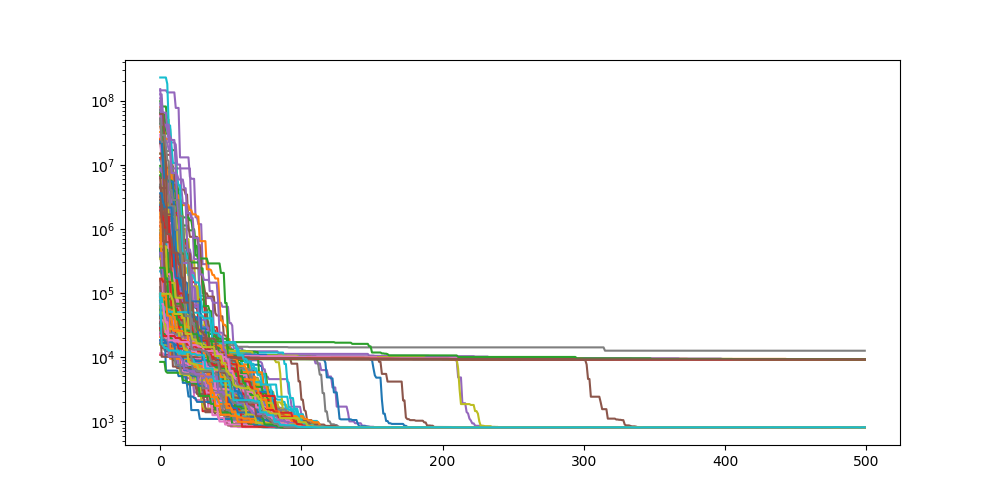

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:07<00:00, 90.05it/s]


In [245]:
with Pool() as pool:
    if gl_alpha is None:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(r_log, sig, gl_n_planets, masks), pool=pool)
        #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(r_log, sig, gl_n_planets, masks), moves=emcee.moves.GaussianMove(cov), pool=pool)
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_alpha, args=(r_log, sig, gl_n_planets, masks, gl_alpha), pool=pool)
        
    state = sampler.run_mcmc(pos, n_burnin, progress=True)
    
    f0, ax0 = plt.subplots(figsize=(10, 5))
    ax0.semilogy(np.arange(sampler.lnprobability.shape[-1]), -sampler.lnprobability.T);
    
    new_pos             = state.coords.copy()
    # set multiplier at the end to ~1.15 to remove single outliers
    good_mask           = sampler.lnprobability[:, -1] > np.median(sampler.lnprobability[:, -1]) * 1.5
    good_indices        = np.where(good_mask)[0]
    new_good_indices    = np.random.choice(good_indices, size=(~good_mask).sum())
    new_pos[~good_mask] = new_pos[new_good_indices]

    sampler.reset()

    sampler.run_mcmc(new_pos, n_steps, progress=True)

In [246]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
try:
    print(sampler.get_autocorr_time())
except Exception: 
    print(Exception)

Mean acceptance fraction: 0.597
<class 'Exception'>


In [247]:
len(new_good_indices)

29

<IPython.core.display.Javascript object>


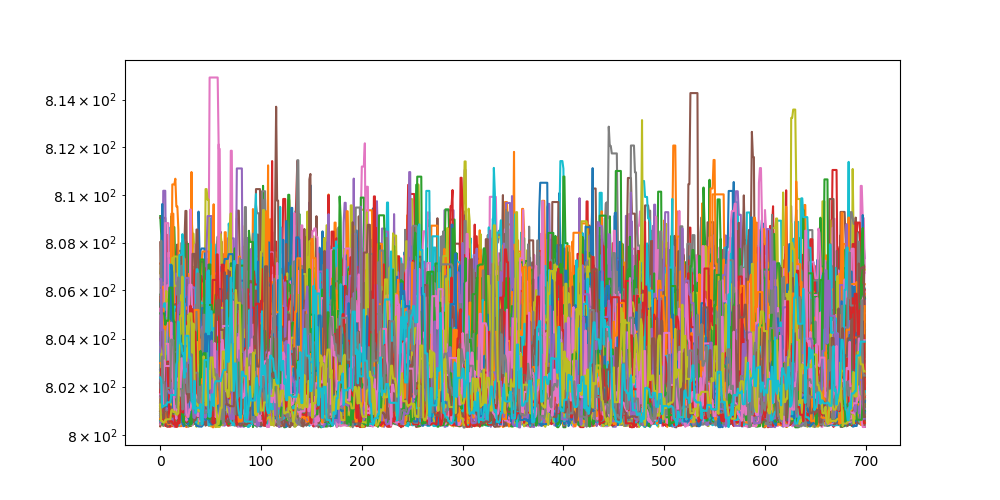

In [248]:
f, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(np.arange(sampler.lnprobability.shape[-1]), -sampler.lnprobability.T);

<IPython.core.display.Javascript object>


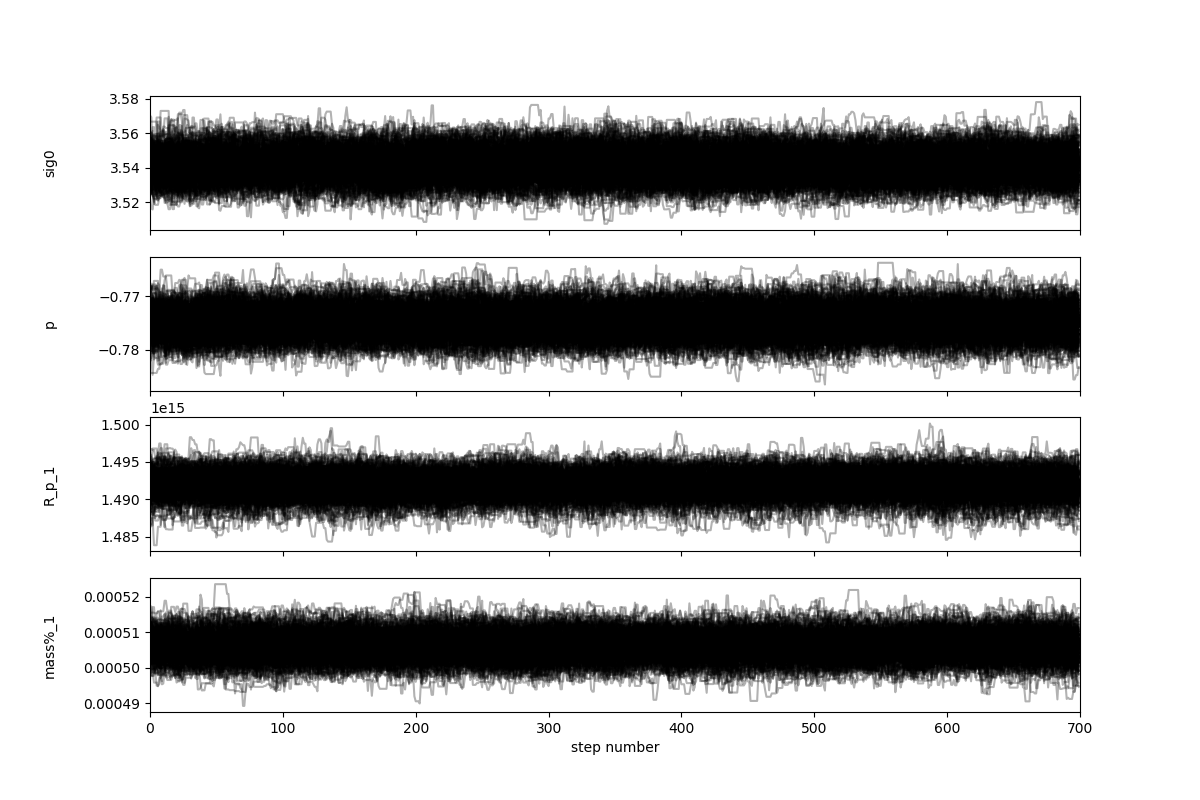

(700, 300, 4)

In [249]:
fig, axes = plt.subplots(ndim, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "sig0", "p"]

if set_alpha == 1:
    labels = labels[1:]
    
for i in range(gl_n_planets):
    labels.append("R_p"+"_"+str(i+1))
    #samples[:,:,3+i-set_alpha] = samples[:,:,3+i-set_alpha]/au
    # 'mass%' instead of 'mass_ratio' because latter is too long
    labels.append("mass%"+"_"+str(i+1))
    
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
samples.shape

In [250]:
flat_samples = sampler.get_chain(discard=200, flat=True)
means = []
mcmc = []
mass_percentile  = []
print("50th percentiles:")
for i in range(ndim):
    means += [np.mean(flat_samples[:,i])]
    mcmc += [np.percentile(flat_samples[:, i], 50)]
    print(labels[i], ":", mcmc[i])

for n in [16, 50, 84]:
    mass_percentile += [np.percentile(flat_samples[:, i], n)]
#print("50th percentiles: ", mcmc)

50th percentiles:
sig0 : 3.541784255700355
p : -0.774851468664214
R_p_1 : 1491817489912658.8
mass%_1 : 0.0005060964709165353


In [251]:
if set_alpha == 1:
    #M_true = 4e-4
    #alt_alpha = means[3]**-2 * gl_alpha *M_true**2
    #print("Alternative Alpha: 10^", np.log10(alt_alpha))
    print("mean values: ", means)
    #product = means[3]**2 * gl_alpha**(-1.1)
    #M_r_es = (product*gl_alpha)**(1/2)
    M_ratio_estimate = np.array(mass_percentile) * gl_alpha**(0.1/2)
    print("mass% estimate:",M_ratio_estimate[1])

mean values:  [3.541752503863779, -0.7748335644885816, 1491873321818805.0, 0.0005061053904237774]
mass% estimate: 0.00040200671634332016


<IPython.core.display.Javascript object>


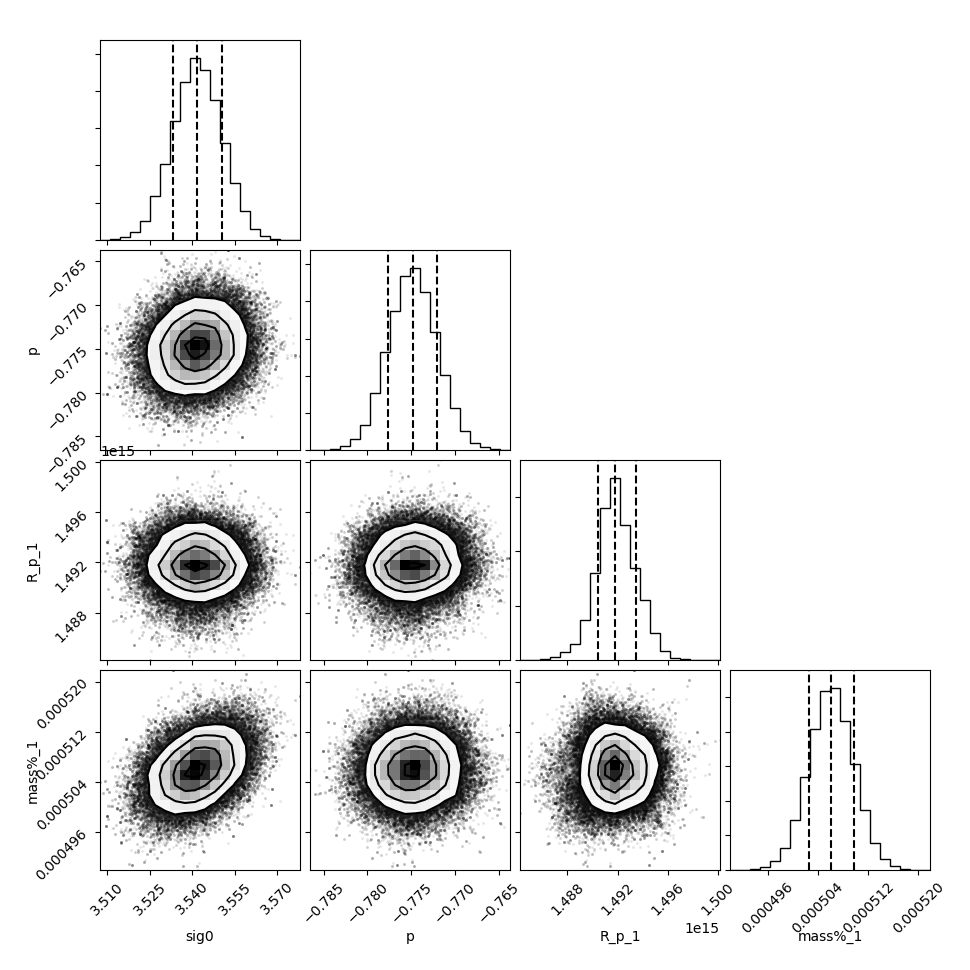

In [252]:
import corner
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

In [253]:
if set_alpha == 1:
    def params_format(params, x_data, y_data, n_planets):
        params = np.insert(params,0,gl_alpha)
        alpha = params[0]
        sig0  = params[1]
        p     = params[2]
        R_p   = []
        mass_ratios = []
        h_p = []
        for n in range(n_planets):
            R_p         += [params[3 + 2 * n]]
            mass_ratios += [params[4 + 2 * n]]
            h_p += [np.interp(R_p, x_data, get_disk_height(x_data))[n]]

        return x_data, alpha, sig0, p, R_p, h_p, mass_ratios

In [254]:
#flat_samples[:,2] = flat_samples[:,2]*au

<IPython.core.display.Javascript object>


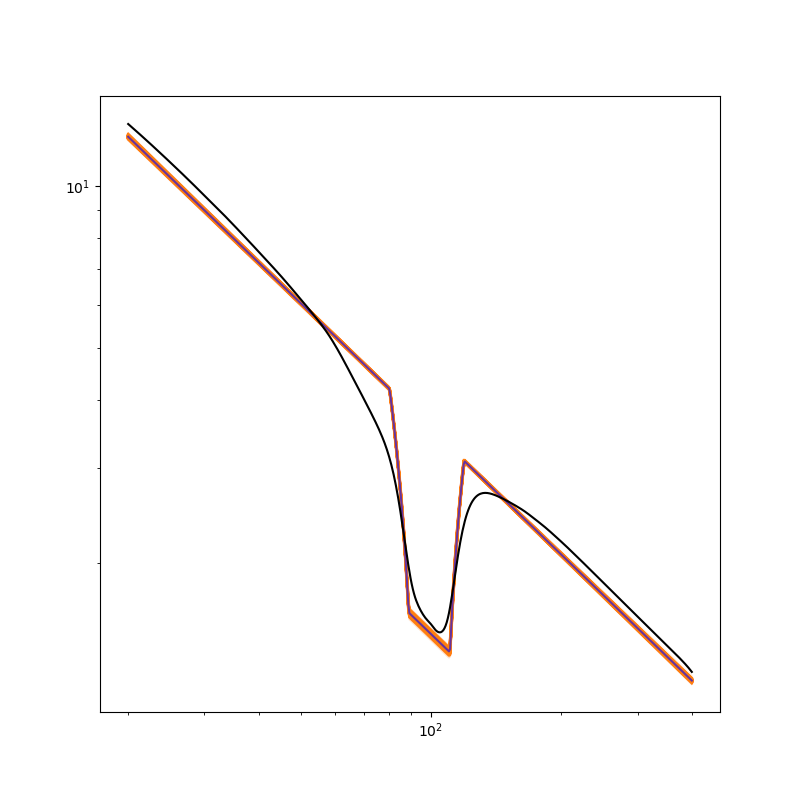

In [255]:
inds = np.random.randint(len(flat_samples), size=1000)
f, ax2 = plt.subplots(figsize=(8, 8))
for ind in inds:
    sample = flat_samples[ind]
    x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(sample, r_log, sig, gl_n_planets)
    ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios), "C1", alpha=0.1)
    
x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(np.array(mcmc), r_log, sig, gl_n_planets)
ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios), "b", alpha=0.6)
ax2.loglog(r_log[0:] / au, sig[0:], "k-");